# Prestazioni

Sono state fatte due analisi

- Prestazioni al variare del numero di individui generati.
- Prestazioni al variare del numero di feature che compongono i dati.


In [1]:
import pandas as pd

rf = pd.read_csv("../results/performance/ppga_RandomForestClassifier_pop_final2.csv")
mlp = pd.read_csv("../results/performance/ppga_MLPClassifier_pop_final2.csv")
svm = pd.read_csv("../results/performance/ppga_SVC_pop_final2.csv")

ppga_df = pd.concat([rf, mlp, svm], axis=0)
ppga_df = (
    ppga_df.groupby(by=["classifier", "population_size", "workers"])
    .mean()[["time", "time_std", "ptime", "ptime_std"]]
    .reset_index()
)

ppga_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std
0,MLPClassifier,1000,1,2.101876,0.037812,0.996361,0.018497
1,MLPClassifier,1000,2,0.827800,0.029654,0.545250,0.007750
2,MLPClassifier,1000,4,0.540733,0.020944,0.266500,0.002250
3,MLPClassifier,1000,8,0.567931,0.029991,0.190375,0.006500
4,MLPClassifier,1000,16,0.624481,0.022891,0.125406,0.004469
...,...,...,...,...,...,...,...
85,SVC,16000,2,15.062810,0.053554,12.181000,0.030000
86,SVC,16000,4,9.028012,0.032707,6.211000,0.024000
87,SVC,16000,8,6.199603,0.081095,3.156687,0.017937
88,SVC,16000,16,5.220522,0.170079,1.755531,0.028031


In [2]:
def compute_speedup(df, field):
    speed_up = []
    for model in df["classifier"].unique():
        for ps in df["population_size"].unique():
            mask1 = (
                (df["classifier"] == model)
                & (df["population_size"] == ps)
                & (df["workers"] == 1)
            )
            a1 = df[mask1][field].to_numpy()
            for w in df["workers"].unique():
                mask = (
                    (df["classifier"] == model)
                    & (df["population_size"] == ps)
                    & (df["workers"] == w)
                )
                a = df[mask][field].to_numpy()
                speed_up.append((a1 / a)[0])
            # print(speed_up[-1])
    if field == "time":
        df["speed_up"] = pd.Series(speed_up)
    else:
        df["p_speed_up"] = pd.Series(speed_up)

    return df


ppga_df = compute_speedup(ppga_df, "time")
ppga_df = compute_speedup(ppga_df, "ptime")
ppga_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std,speed_up,p_speed_up
0,MLPClassifier,1000,1,2.101876,0.037812,0.996361,0.018497,1.000000,1.000000
1,MLPClassifier,1000,2,0.827800,0.029654,0.545250,0.007750,2.539111,1.827347
2,MLPClassifier,1000,4,0.540733,0.020944,0.266500,0.002250,3.887086,3.738690
3,MLPClassifier,1000,8,0.567931,0.029991,0.190375,0.006500,3.700934,5.233675
4,MLPClassifier,1000,16,0.624481,0.022891,0.125406,0.004469,3.365796,7.945066
...,...,...,...,...,...,...,...,...,...
85,SVC,16000,2,15.062810,0.053554,12.181000,0.030000,3.234667,1.914774
86,SVC,16000,4,9.028012,0.032707,6.211000,0.024000,5.396890,3.755250
87,SVC,16000,8,6.199603,0.081095,3.156687,0.017937,7.859081,7.388713
88,SVC,16000,16,5.220522,0.170079,1.755531,0.028031,9.333009,13.285925


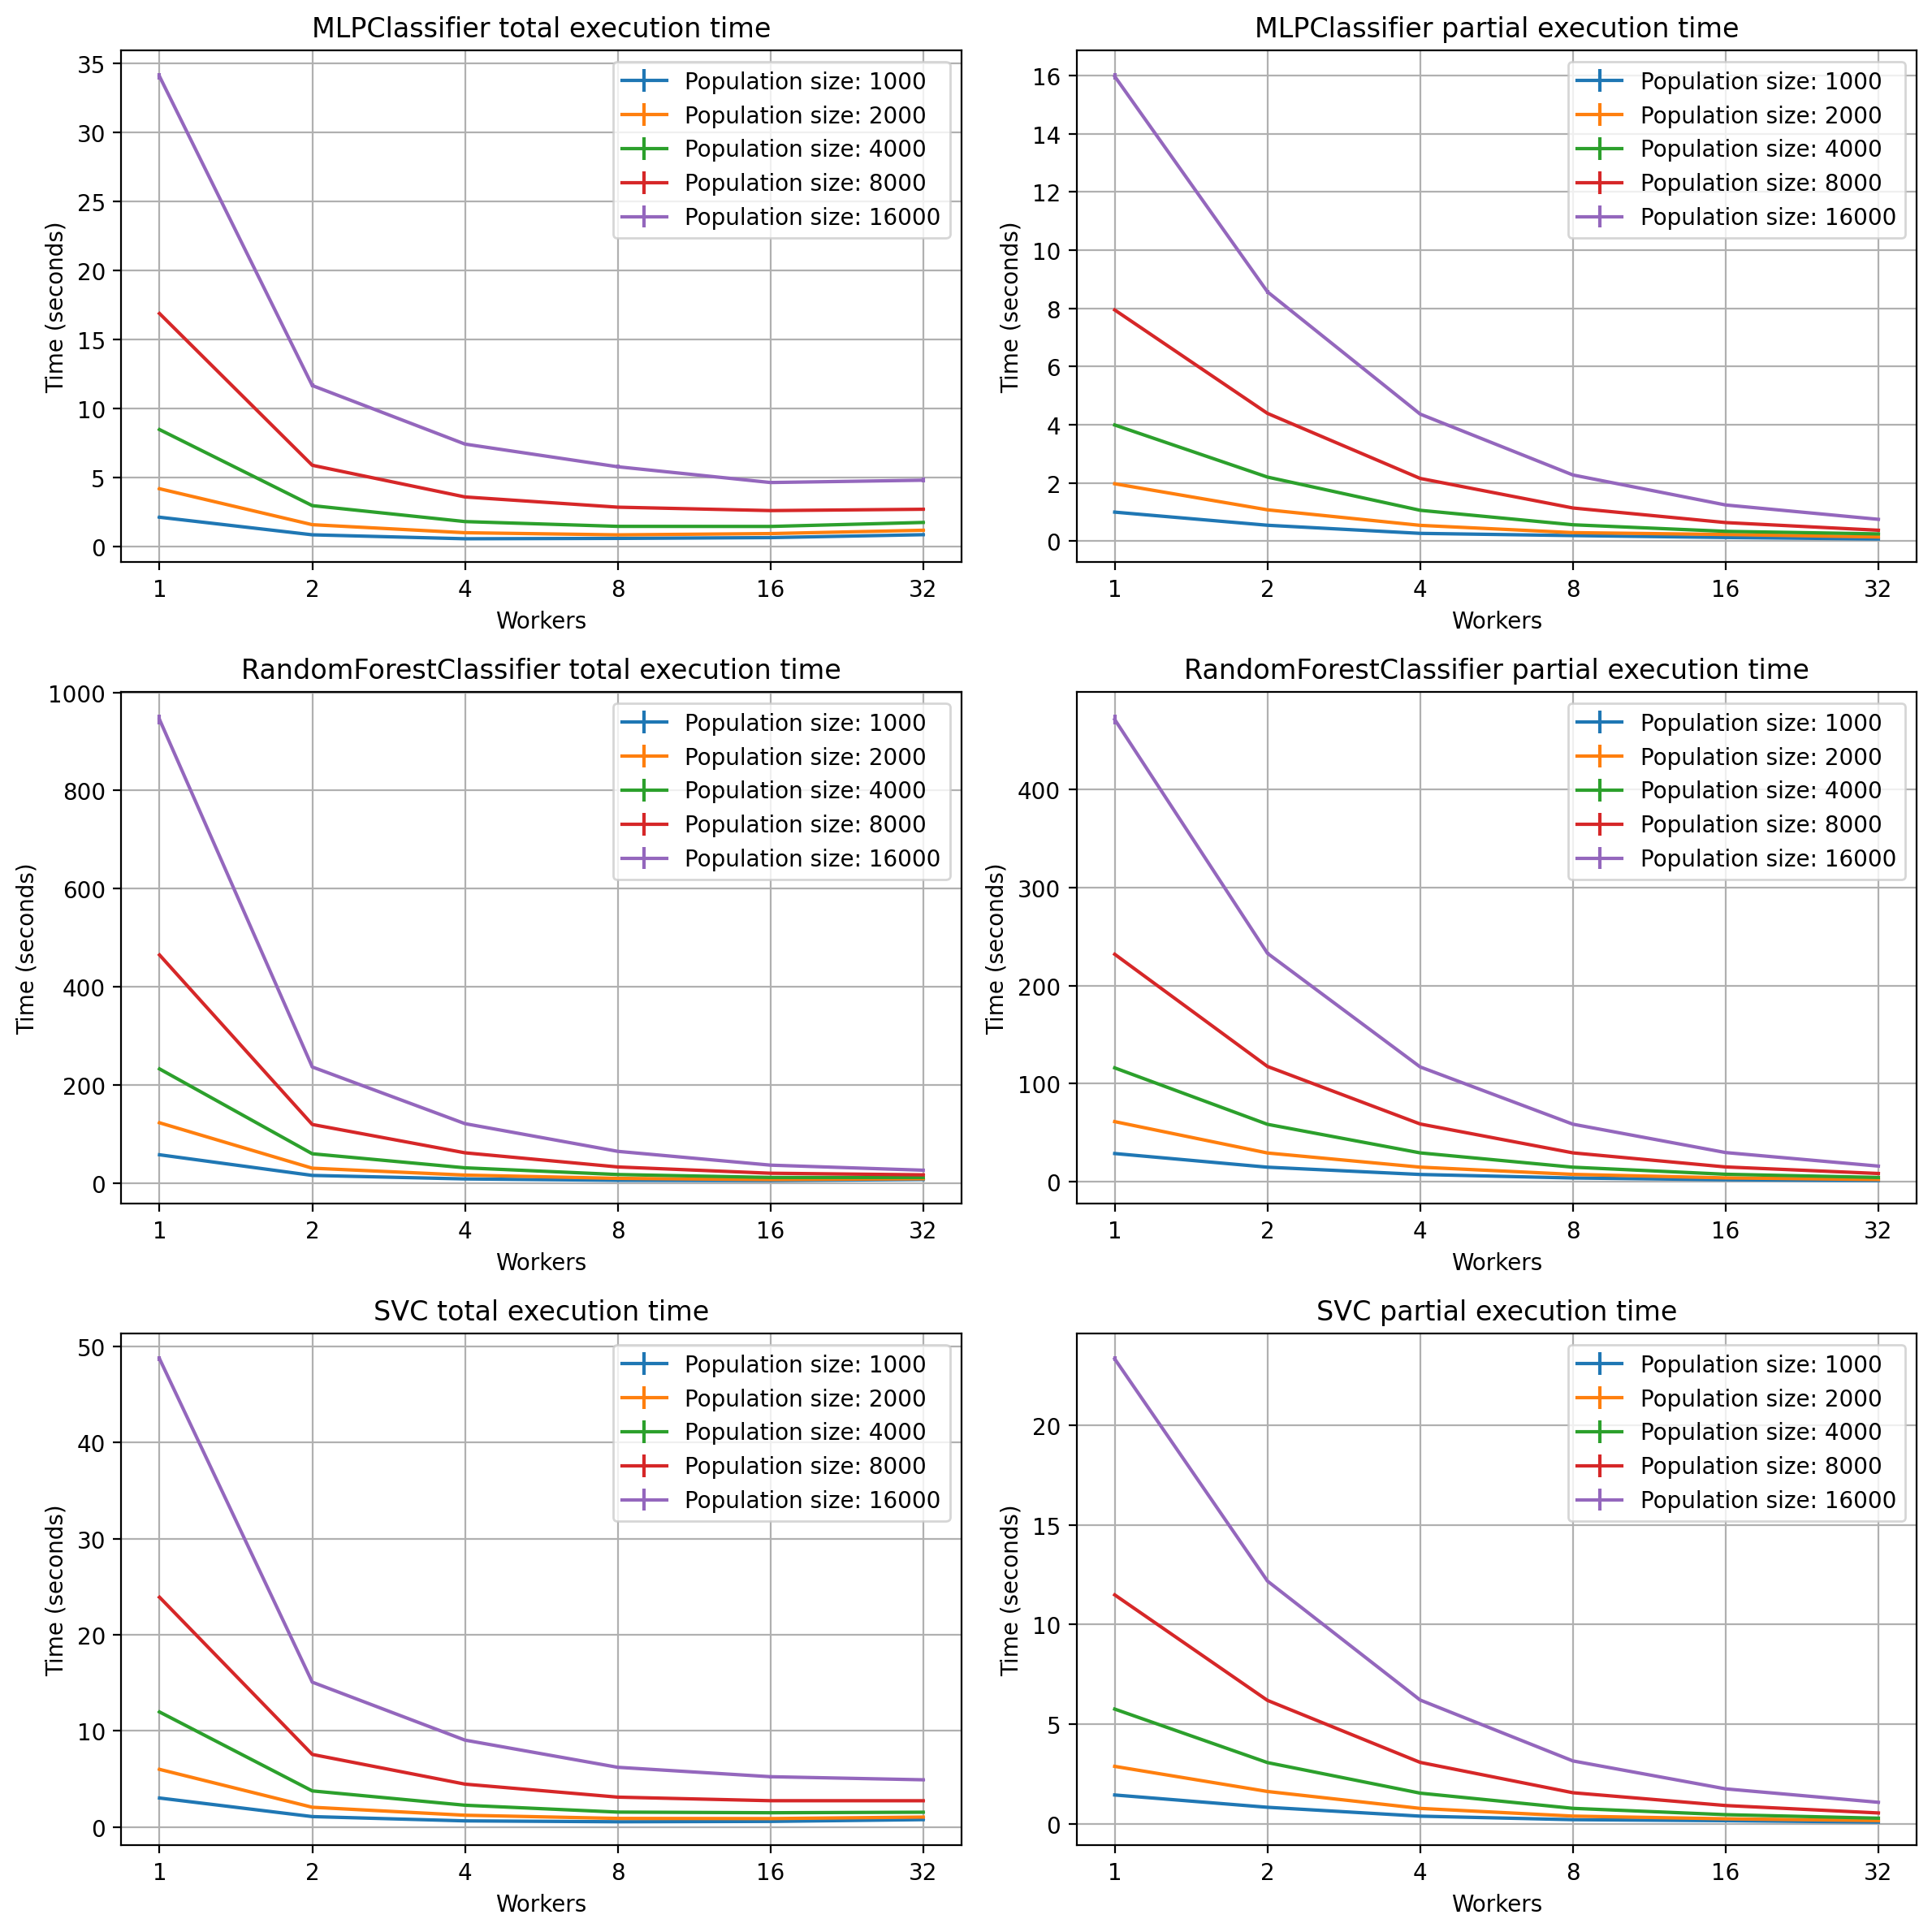

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def plot_time(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(models), 2, figsize=(12, 12), dpi=200)

    for i, model in enumerate(models):
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i, 0].set_title(f"{model} total execution time")
            axes[i, 0].set_xlabel("Workers")
            axes[i, 0].set_ylabel("Time (seconds)")
            axes[i, 0].errorbar(
                workers,
                df[mask]["time"].values,
                df[mask]["time_std"],
                label=f"Population size: {ps}",
            )

            axes[i, 0].set_xscale("log", base=2)
            axes[i, 0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 0].grid()
            axes[i, 0].legend()

            axes[i, 1].set_title(f"{model} partial execution time")
            axes[i, 1].set_xlabel("Workers")
            axes[i, 1].set_ylabel("Time (seconds)")
            axes[i, 1].errorbar(
                workers,
                df[mask]["ptime"].values,
                df[mask]["ptime_std"],
                label=f"Population size: {ps}",
            )

            axes[i, 1].set_xscale("log", base=2)
            axes[i, 1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 1].grid()
            axes[i, 1].legend()

    plt.tight_layout()
    plt.show()


plot_time(ppga_df)

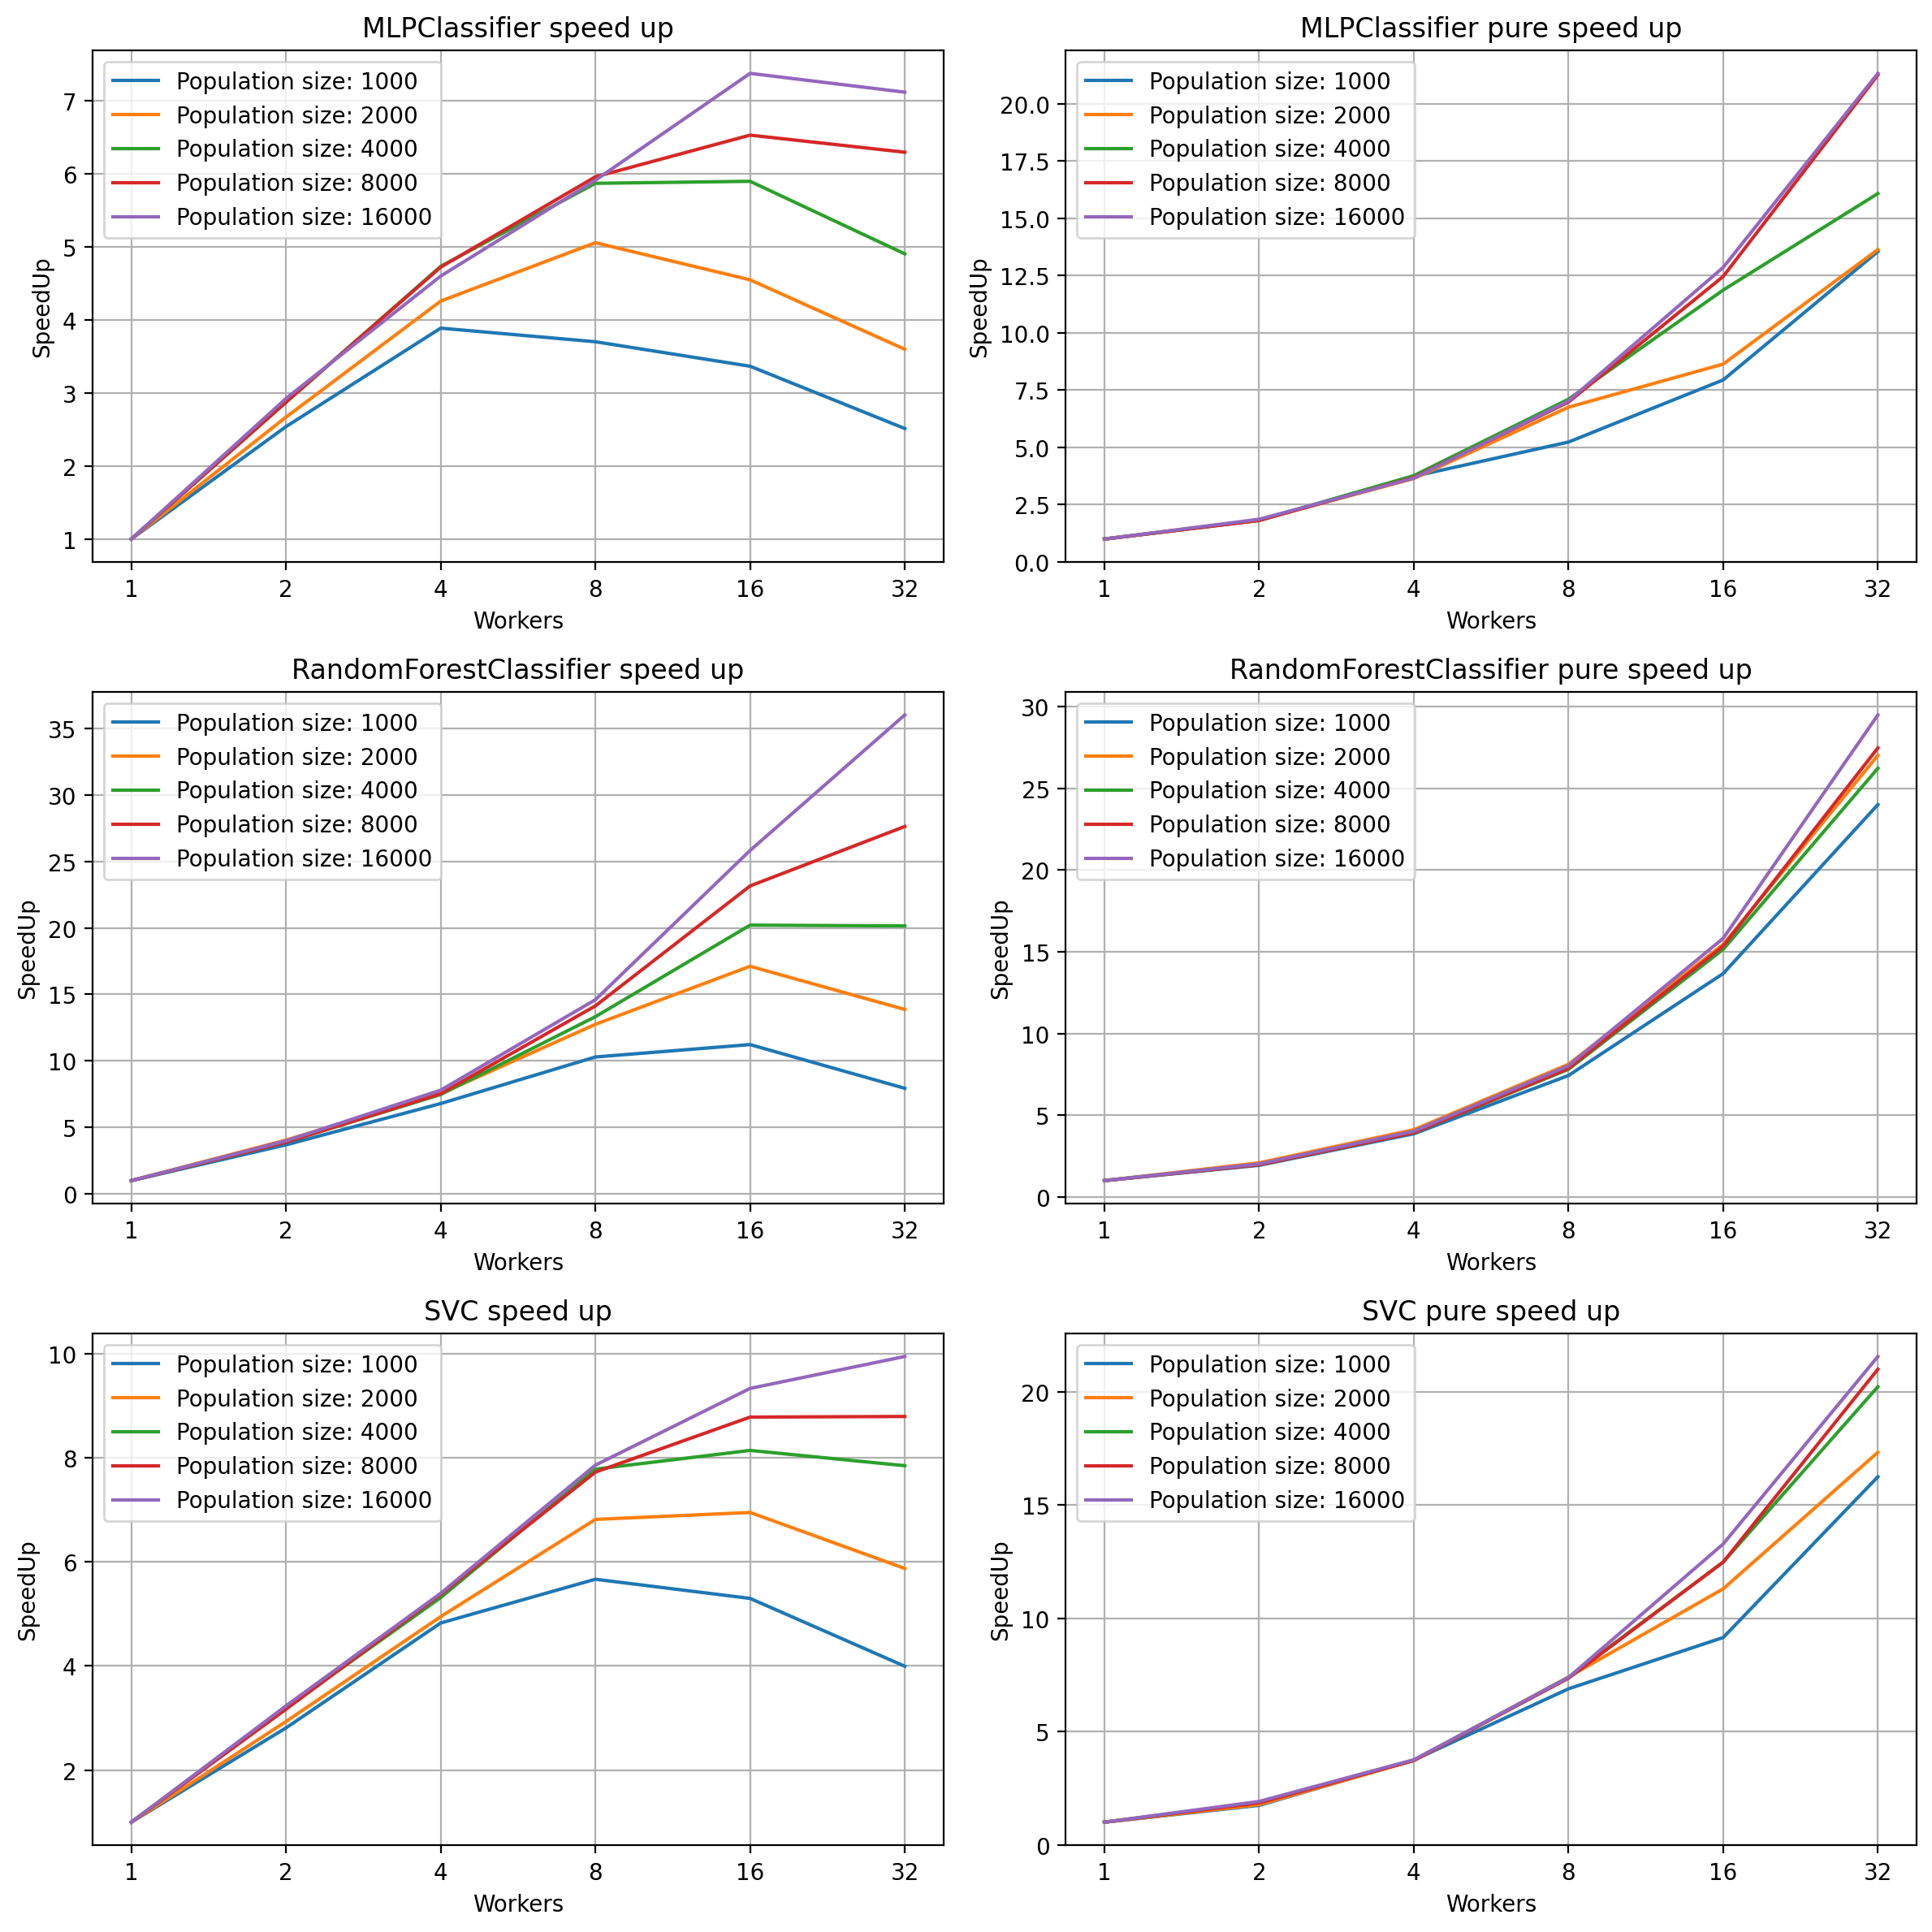

In [4]:
def plot_speedup(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(models), 2, figsize=(12, 12), dpi=200)

    for i, model in enumerate(models):
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[i, 0].set_title(f"{model} speed up")
            axes[i, 0].set_xlabel("Workers")
            axes[i, 0].set_ylabel("SpeedUp")
            axes[i, 0].plot(
                workers,
                df[mask]["speed_up"].to_numpy(),
                label=f"Population size: {ps}",
            )

            axes[i, 0].set_xscale("log", base=2)
            axes[i, 0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 0].grid()
            axes[i, 0].legend()

            axes[i, 1].set_title(f"{model} pure speed up")
            axes[i, 1].set_xlabel("Workers")
            axes[i, 1].set_ylabel("SpeedUp")
            axes[i, 1].plot(
                workers,
                df[mask]["p_speed_up"],
                label=f"Population size: {ps}",
            )

            axes[i, 1].set_xscale("log", base=2)
            axes[i, 1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[i, 1].grid()
            axes[i, 1].legend()

    plt.tight_layout()
    plt.show()


plot_speedup(ppga_df)

In [5]:
mlp = pd.read_csv("../results/performance/deap_MLPClassifier_pop_laptop.csv")
# svm = pd.read_csv("../results/performance/deap_SVC_pop_final2.csv")
# rf = pd.read_csv("../results/performance/deap_RandomForestClassifier_pop_final2.csv")

deap_df = pd.concat([mlp], axis=0)
deap_df = (
    deap_df.groupby(by=["classifier", "population_size", "workers"])
    .mean()[["time", "time_std", "ptime", "ptime_std"]]
    .sort_values(by=["classifier", "population_size", "workers"])
    .reset_index()
)

deap_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std
0,MLPClassifier,2000,1,2.552324,0.013920,0.000113,0.000007
1,MLPClassifier,2000,4,2.597773,0.075043,0.481250,0.025000
2,MLPClassifier,2000,14,2.700562,0.055879,0.211250,0.006071
3,MLPClassifier,8000,1,20.383881,0.183728,0.000342,0.000002
4,MLPClassifier,8000,4,19.830870,0.129891,1.788125,0.031875
5,MLPClassifier,8000,14,18.679033,0.082205,0.588929,0.044286


In [6]:
deap_df = compute_speedup(deap_df, "time")
deap_df = compute_speedup(deap_df, "ptime")
deap_df

,classifier,population_size,workers,time,time_std,ptime,ptime_std,speed_up,p_speed_up
0,MLPClassifier,2000,1,2.552324,0.013920,0.000113,0.000007,1.000000,1.000000
1,MLPClassifier,2000,4,2.597773,0.075043,0.481250,0.025000,0.982505,0.000236
2,MLPClassifier,2000,14,2.700562,0.055879,0.211250,0.006071,0.945108,0.000537
3,MLPClassifier,8000,1,20.383881,0.183728,0.000342,0.000002,1.000000,1.000000
4,MLPClassifier,8000,4,19.830870,0.129891,1.788125,0.031875,1.027886,0.000191
5,MLPClassifier,8000,14,18.679033,0.082205,0.588929,0.044286,1.091271,0.000581


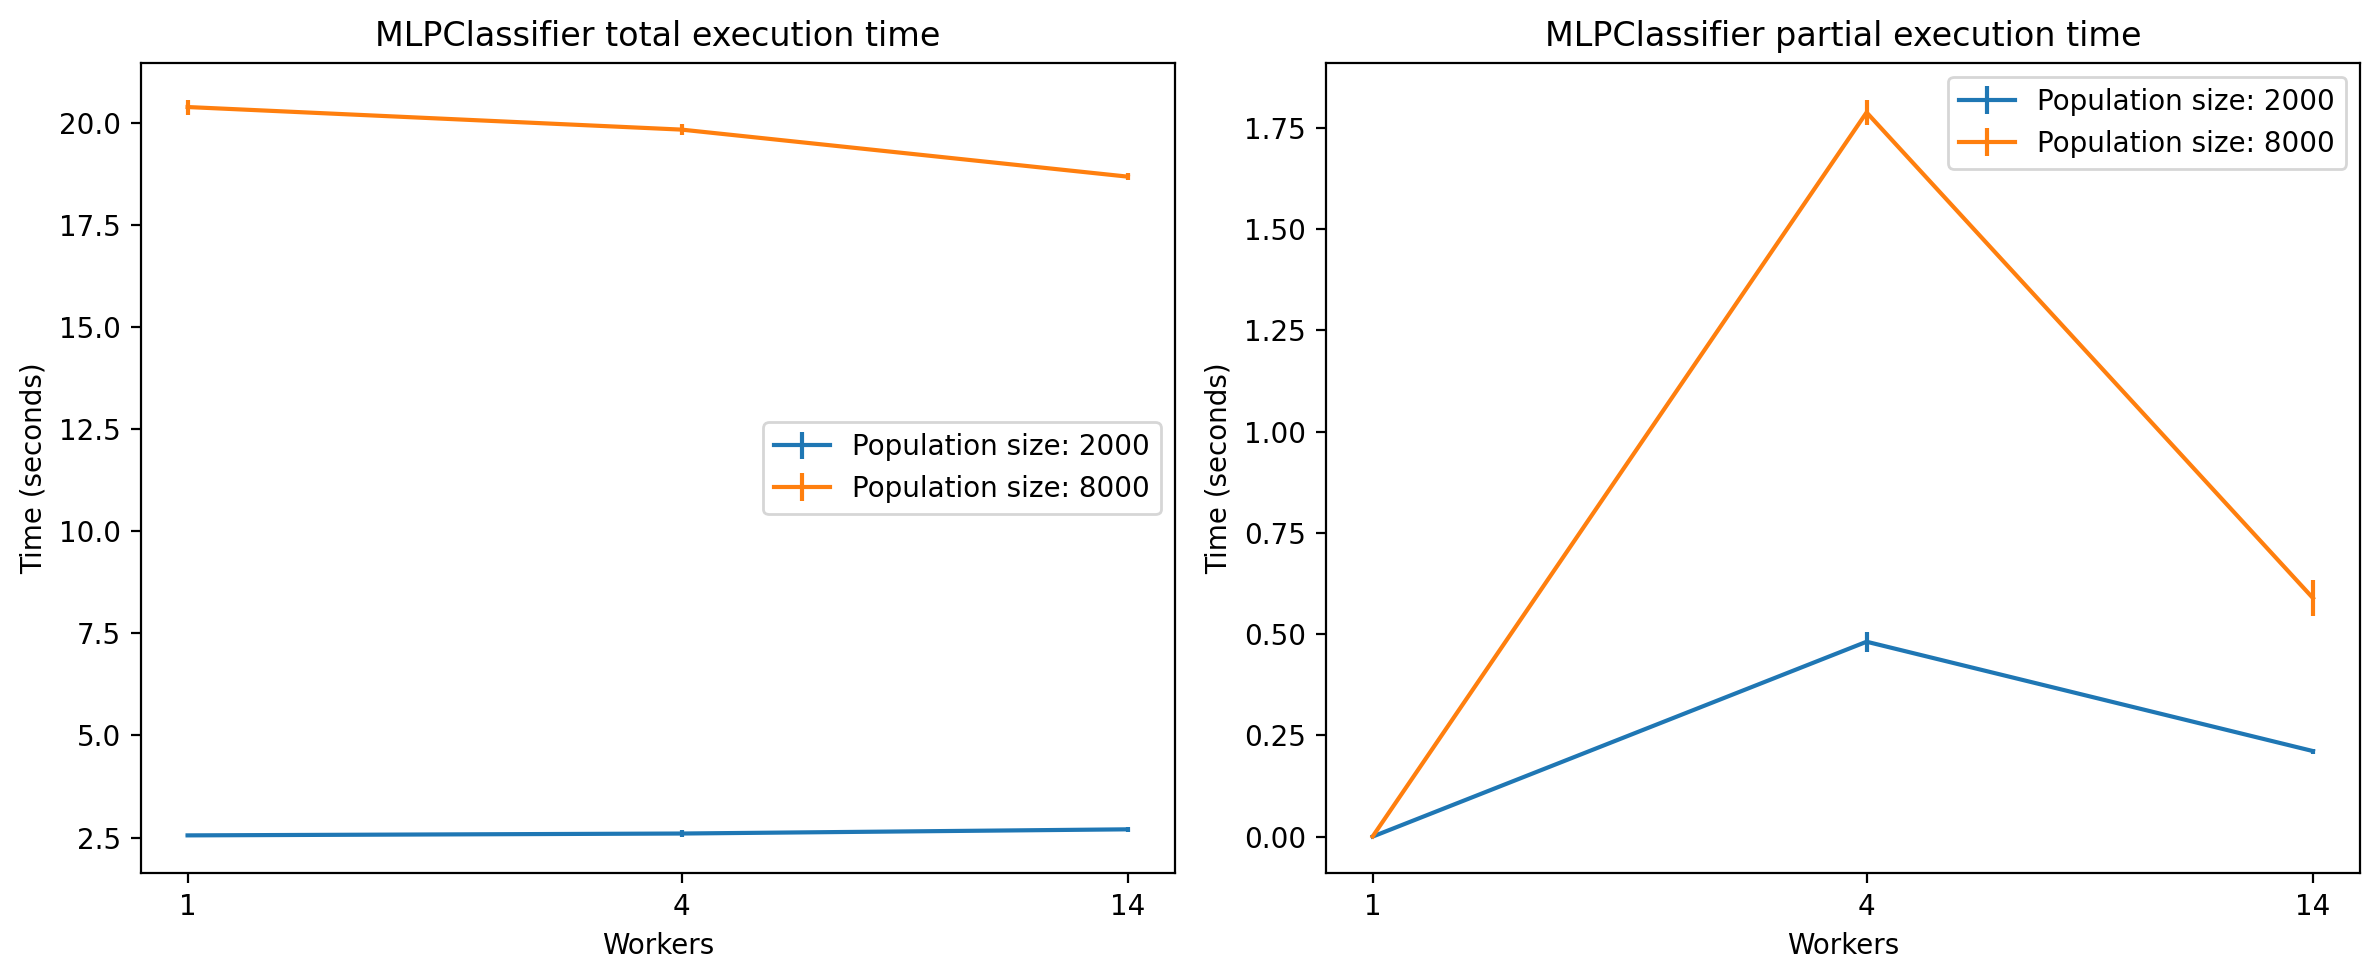

In [16]:
def plot_time2(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(len(models), 2, figsize=(12, 5), dpi=200)

    for i, model in enumerate(models):
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[0].set_title(f"{model} total execution time")
            axes[0].set_xlabel("Workers")
            axes[0].set_ylabel("Time (seconds)")
            axes[0].errorbar(
                workers,
                df[mask]["time"].values,
                df[mask]["time_std"],
                label=f"Population size: {ps}",
            )

            axes[0].set_xscale("log", base=2)
            axes[0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[0].grid()
            axes[0].legend()

            axes[1].set_title(f"{model} partial execution time")
            axes[1].set_xlabel("Workers")
            axes[1].set_ylabel("Time (seconds)")
            axes[1].errorbar(
                workers,
                df[mask]["ptime"].values,
                df[mask]["ptime_std"],
                label=f"Population size: {ps}",
            )

            axes[1].set_xscale("log", base=2)
            axes[1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[1].grid()
            axes[1].legend()

    plt.tight_layout()
    plt.show()


plot_time2(deap_df)

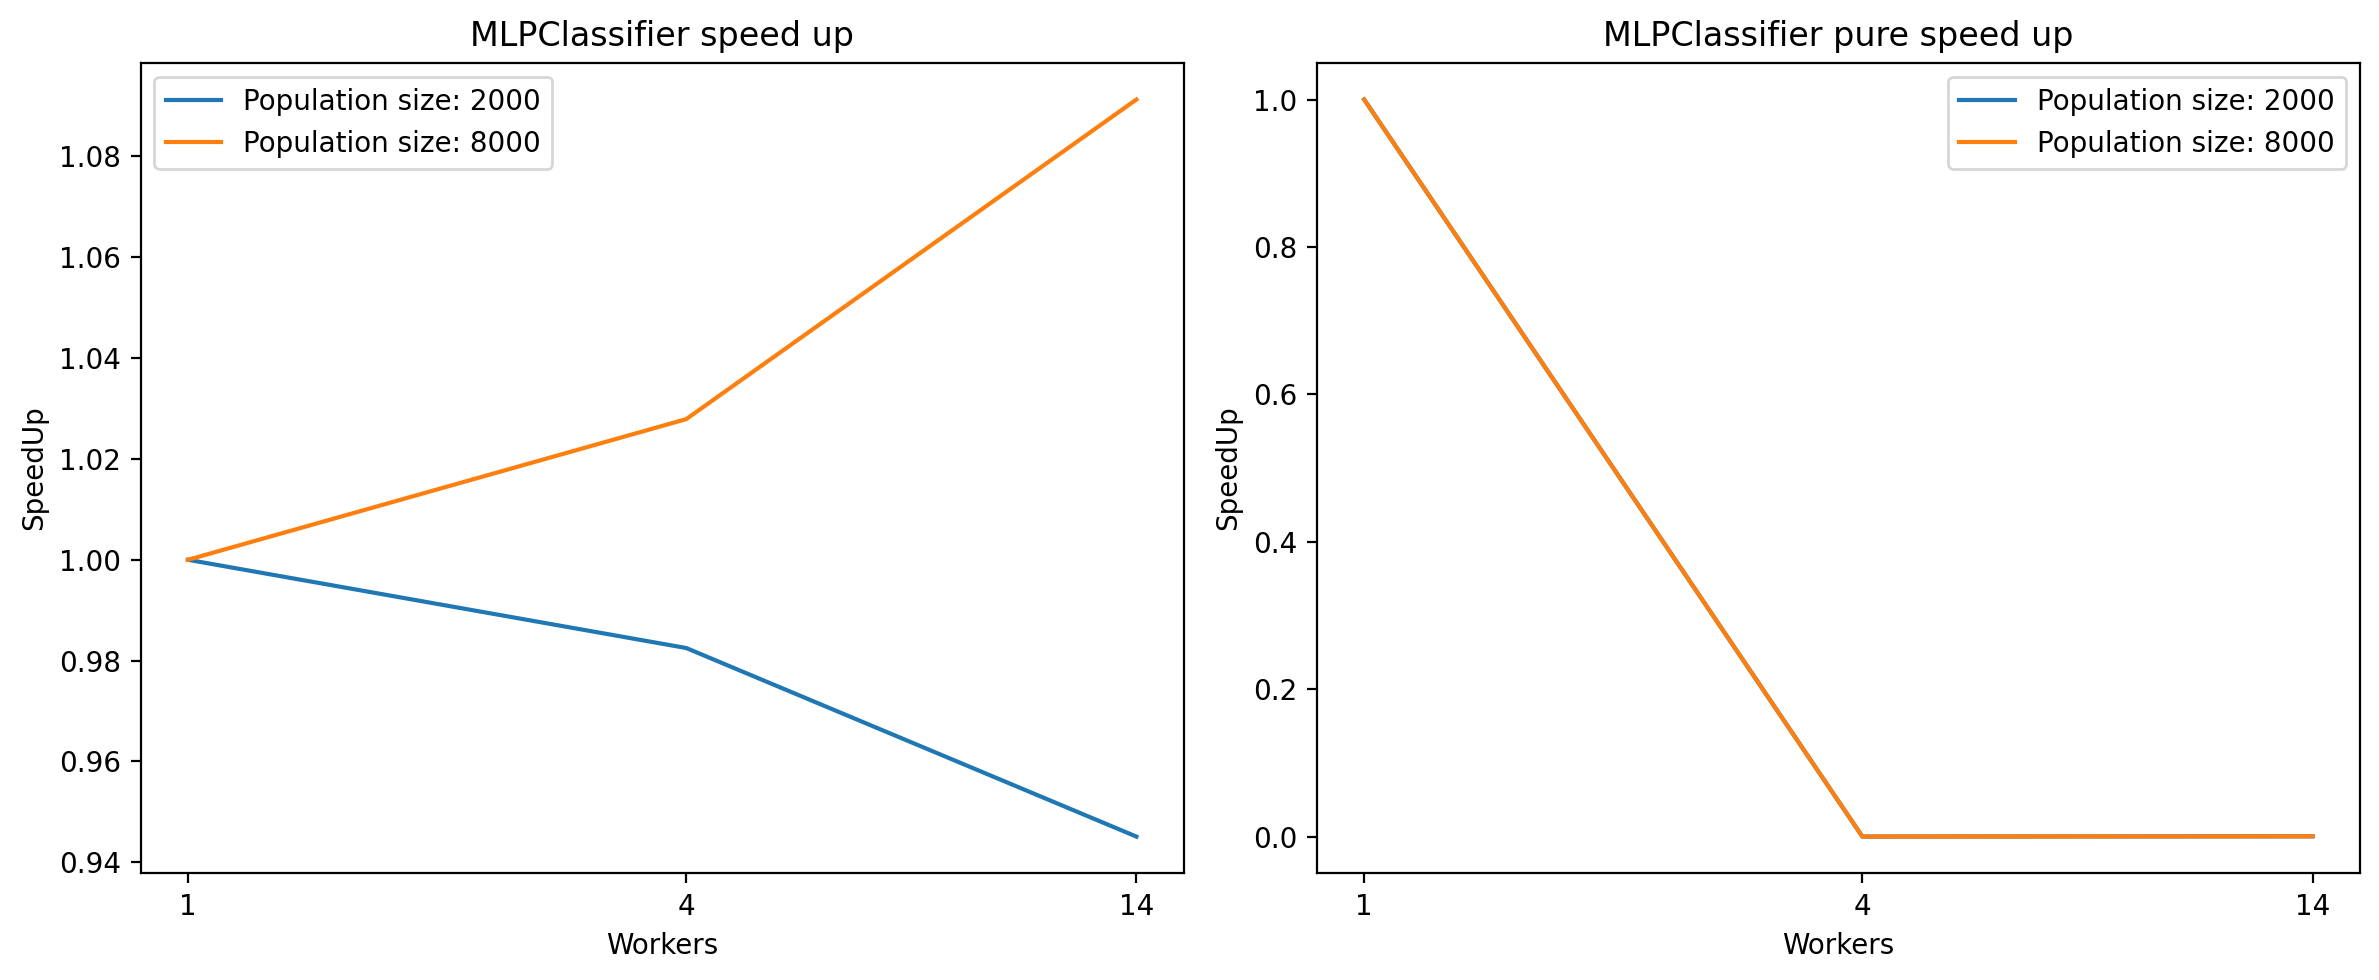

In [19]:
def plot_speedup2(df):
    models = df["classifier"].unique()
    workers = df["workers"].unique()
    population_sizes = df["population_size"].unique()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

    for i, model in enumerate(models):
        for ps in population_sizes:
            mask = (df["classifier"] == model) & (df["population_size"] == ps)
            axes[0].set_title(f"{model} speed up")
            axes[0].set_xlabel("Workers")
            axes[0].set_ylabel("SpeedUp")
            axes[0].plot(
                workers,
                df[mask]["speed_up"].to_numpy(),
                label=f"Population size: {ps}",
            )

            axes[0].set_xscale("log", base=2)
            axes[0].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[0].grid()
            axes[0].legend()

            axes[1].set_title(f"{model} pure speed up")
            axes[1].set_xlabel("Workers")
            axes[1].set_ylabel("SpeedUp")
            axes[1].plot(
                workers,
                df[mask]["p_speed_up"],
                label=f"Population size: {ps}",
            )

            axes[1].set_xscale("log", base=2)
            axes[1].set_xticks(workers, labels=[int(2**w) for w in np.log2(workers)])
            axes[1].grid()
            axes[1].legend()

    plt.tight_layout()
    plt.show()


plot_speedup2(deap_df)